# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

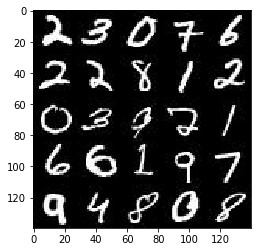

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

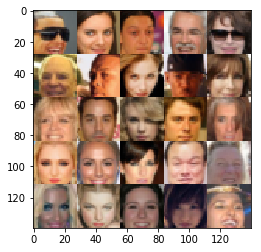

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_images")
    input_zs = tf.placeholder(tf.float32, (None, z_dim), name='input_zs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    #return inputs_real, inputs_z
    return input_images, input_zs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha=0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_images, input_zs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, input_zs, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    idx = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                idx += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                
                if idx % 100 == 0:
                    show_generator_output(sess, 16, input_zs, data_shape[3], data_image_mode)
                
                if idx % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_zs: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({input_zs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 6.3823
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 2.3572... Generator Loss: 1.9158
Epoch 1/2... Discriminator Loss: 2.3112... Generator Loss: 0.2408
Epoch 1/2... Discriminator Loss: 2.0565... Generator Loss: 0.3124
Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 0.4175
Epoch 1/2... Discriminator Loss: 1.9762... Generator Loss: 0.2957
Epoch 1/2... Discriminator Loss: 1.7220... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.8475... Generator Loss: 0.3568


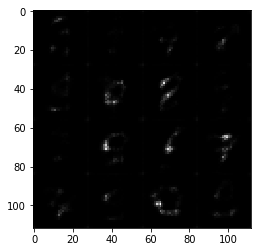

Epoch 1/2... Discriminator Loss: 1.7442... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.7226... Generator Loss: 0.4356
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 1.6202... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.6716... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.6108... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.8133... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.6848... Generator Loss: 0.8951
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.3812


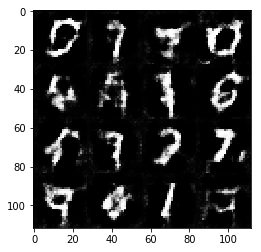

Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.7617... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 1.7062... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.4770... Generator Loss: 0.7292
Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.6880... Generator Loss: 0.3869
Epoch 1/2... Discriminator Loss: 1.5383... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.5574... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.5745... Generator Loss: 0.7305


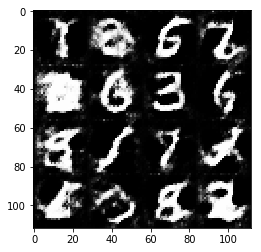

Epoch 1/2... Discriminator Loss: 1.7400... Generator Loss: 0.3802
Epoch 1/2... Discriminator Loss: 1.4959... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.5637... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.7650... Generator Loss: 0.3193
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 0.3246
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 2.1104... Generator Loss: 0.2082
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 0.5645


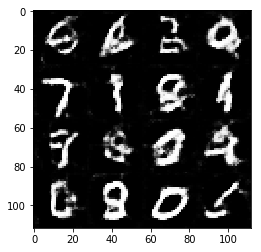

Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.7952... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.8374... Generator Loss: 0.2933
Epoch 1/2... Discriminator Loss: 1.6736... Generator Loss: 0.3791


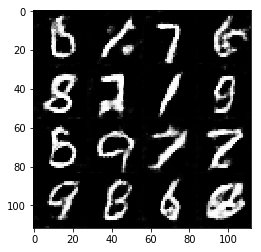

Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 1.9101... Generator Loss: 0.2622
Epoch 1/2... Discriminator Loss: 2.1681... Generator Loss: 0.2013
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.4350
Epoch 1/2... Discriminator Loss: 1.8576... Generator Loss: 0.2854
Epoch 1/2... Discriminator Loss: 1.8487... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 1.5002... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.6012... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.4942


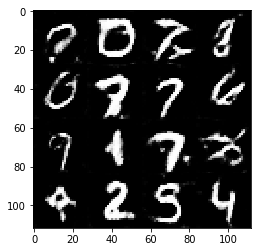

Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.5529... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 1.1415
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.7570... Generator Loss: 0.3449
Epoch 1/2... Discriminator Loss: 2.0162... Generator Loss: 0.2301
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7678


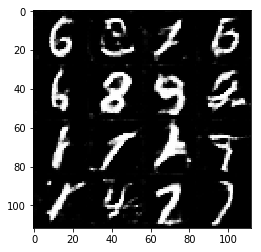

Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.8257... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.6390
Epoch 1/2... Discriminator Loss: 1.6079... Generator Loss: 0.4415
Epoch 1/2... Discriminator Loss: 1.8922... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.5432


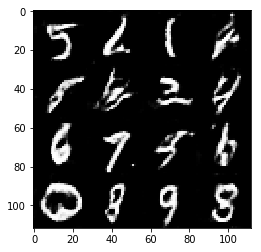

Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.7316... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.3482
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.7050... Generator Loss: 0.3362
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.6391


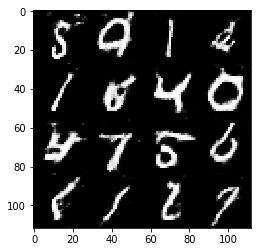

Epoch 1/2... Discriminator Loss: 1.5729... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.5669... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 2.2624... Generator Loss: 0.1781
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8124
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.5552
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.4666... Generator Loss: 0.5133


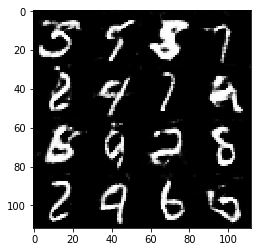

Epoch 2/2... Discriminator Loss: 1.4840... Generator Loss: 1.0342
Epoch 2/2... Discriminator Loss: 1.6655... Generator Loss: 0.4178
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.4615... Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.9777... Generator Loss: 0.2651
Epoch 2/2... Discriminator Loss: 1.5528... Generator Loss: 0.4513
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.8476... Generator Loss: 0.3075
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 1.0816


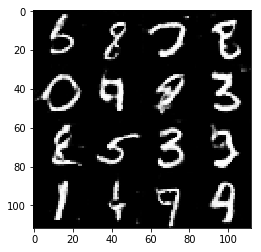

Epoch 2/2... Discriminator Loss: 1.7595... Generator Loss: 0.3671
Epoch 2/2... Discriminator Loss: 1.4399... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.4882... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 2.1199... Generator Loss: 0.2335
Epoch 2/2... Discriminator Loss: 1.6106... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 0.6311


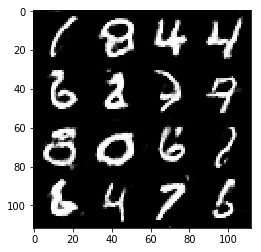

Epoch 2/2... Discriminator Loss: 1.6020... Generator Loss: 0.4113
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.6305... Generator Loss: 0.3976
Epoch 2/2... Discriminator Loss: 1.5709... Generator Loss: 0.3932
Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.8652... Generator Loss: 0.2897
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.5728... Generator Loss: 0.4217
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.6817... Generator Loss: 0.4185


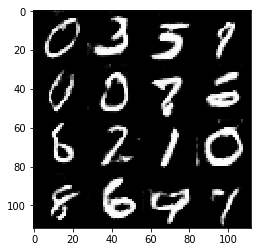

Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.6004... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.5203
Epoch 2/2... Discriminator Loss: 1.4847... Generator Loss: 1.5546
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.8755... Generator Loss: 0.2850
Epoch 2/2... Discriminator Loss: 1.5388... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.9633


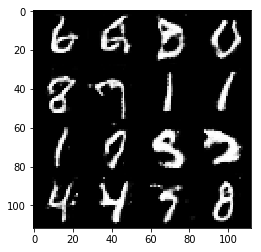

Epoch 2/2... Discriminator Loss: 1.9914... Generator Loss: 0.2442
Epoch 2/2... Discriminator Loss: 1.5988... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 1.0466
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 1.6695... Generator Loss: 0.3756
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.9778... Generator Loss: 0.2637


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.